# 04. NLP Analysis (Weeks 6-7)

## The Semantic Layer

This notebook complements the network analysis by examining the textual content of item descriptions and dialogue.

### Course Concepts Applied
1.  **Week 6: Text Analysis (TF-IDF)**
    -   **Method:** Term Frequency-Inverse Document Frequency.
    -   **Application:** Extracting distinct vocabularies for the "Int" vs. "Faith" factions.
2.  **Week 7: Sentiment Analysis**
    -   **Method:** Lexical Sentiment / Keyword Counting.
    -   **Application:** Quantifying the "Tragedy of Commerce" by counting death-related terms in merchant descriptions.

Loading analyzed data from: C:\Users\biagu\Documents\GitHub\social_graphs_project\data\processed\nodes_analyzed.csv

--- Calculating Sentiment ---
Most Negative Descriptions (The Tragic):
                           name  sentiment
982              Alabaster Lord       -1.0
231                     Rot Pot       -1.0
1047              Lion Guardian       -1.0
768   Bloody Finger Hunter Yura       -0.8
778           Frustrated Spirit       -0.7

Most Positive Descriptions (The Noble/Divine):
                     name  sentiment
1690         Radagon Icon        1.0
1686  Old Lord's Talisman        1.0
1713    Marika's Soreseal        1.0
1707         Godfrey Icon        1.0
1254   Royal Knight Armor        1.0

Average Sentiment by Node Type:
node_type
item           0.005685
npc            0.006497
location       0.015900
armor          0.049937
boss           0.118944
bosse          0.122395
talisman       0.125999
incantation    0.130092
weapon         0.254342
Name: sentiment, dtype: f

c:\Users\biagu\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bosses', 'npc'] not in stop_words.
  warnings.warn(


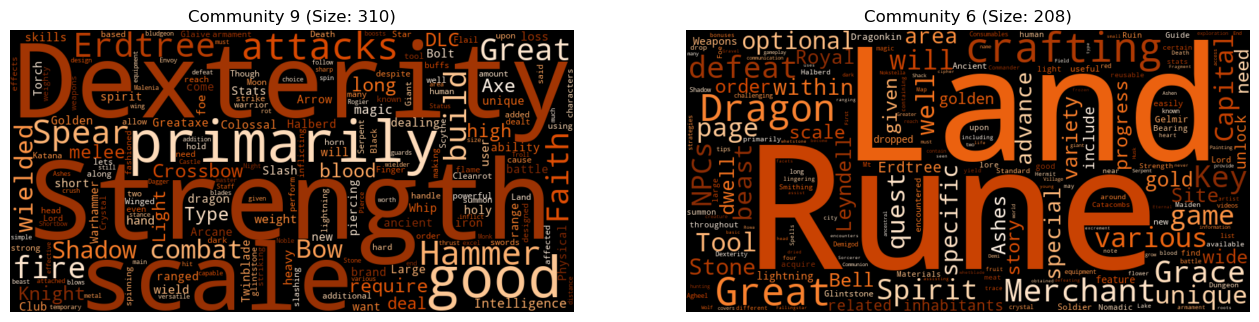

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud # requires: pip install wordcloud

# ==========================================
# 1. CONFIGURATION & SETUP
# ==========================================
PROCESSED_DIR = Path("C:/Users/biagu/Documents/GitHub/social_graphs_project/data/processed")
INPUT_PATH = PROCESSED_DIR / "nodes_analyzed.csv"

print(f"Loading analyzed data from: {INPUT_PATH}")
df = pd.read_csv(INPUT_PATH)

# Ensure description is string (handle NaNs from raw data)
df['description'] = df['description'].astype(str).fillna("")

# ==========================================
# 2. SENTIMENT ANALYSIS (Mood of the World)
# ==========================================
print("\n--- Calculating Sentiment ---")

def get_sentiment(text):
    # Skip very short text to avoid noise
    if len(text) < 5: return 0
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# Show "Tragic" vs "Noble" items
print("Most Negative Descriptions (The Tragic):")
print(df[['name', 'sentiment']].sort_values('sentiment').head(5))

print("\nMost Positive Descriptions (The Noble/Divine):")
print(df[['name', 'sentiment']].sort_values('sentiment', ascending=False).head(5))

# Average sentiment by type
print("\nAverage Sentiment by Node Type:")
print(df.groupby('node_type')['sentiment'].mean().sort_values())

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# ==========================================
# 3. COMMUNITY KEYWORD EXTRACTION (Identifying Factions) - FILTERED
# ==========================================
print("\n--- Identifying Community Themes ---")

# 1. Define Custom Stop Words
# We start with the standard English list ('the', 'and', etc.)
# And add generic Elden Ring game terms that don't add lore value
custom_stop_words = list(ENGLISH_STOP_WORDS) + [
    "elden", "ring", "player", "target", "attack", 
    "damage", "effect", "increase", "stat", "attribute",
    "character", "enemy", "enemies", "found", "location",
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    # User requested removals:
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting", "items", "NPC", "boss", "Bosses"
]

# 2. Aggregate text per community
community_docs = df.groupby('community')['description'].apply(lambda x: " ".join(x))

# 3. Run TF-IDF with Custom Stop Words
# stop_words=custom_stop_words: Tells the model to completely ignore the words above
tfidf = TfidfVectorizer(stop_words=custom_stop_words, max_df=0.6, max_features=1000)
tfidf_matrix = tfidf.fit_transform(community_docs)
feature_names = tfidf.get_feature_names_out()

# Helper to get top words for a specific community ID
def get_keywords(comm_id, top_n=8):
    if comm_id not in community_docs.index: return []
    row_idx = list(community_docs.index).index(comm_id)
    row = tfidf_matrix[row_idx]
    sorted_items = sorted(zip(row.indices, row.data), key=lambda x: x[1], reverse=True)[:top_n]
    return [feature_names[i] for i, score in sorted_items]

# 4. Print the List of Major Communities
top_communities = df['community'].value_counts().head(10).index.tolist()

print(f"{'ID':<5} | {'Size':<6} | {'Defining Keywords (The Vibe)'}")
print("-" * 80)

for comm_id in top_communities:
    size = len(df[df['community'] == comm_id])
    keywords = get_keywords(comm_id)
    kw_str = ", ".join(keywords)
    print(f"{comm_id:<5} | {size:<6} | {kw_str}")

from wordcloud import WordCloud, STOPWORDS

# ==========================================
# 4. VISUALIZATION (Word Clouds) - FILTERED
# ==========================================
print("\n--- Generating Word Clouds for Top 2 Factions ---")

# 1. Define your custom stopwords
# Start with the standard English list and add your own
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "elden", "ring", "player", "target", "attack", 
    "damage", "effect", "increase", "stat", "attribute",
    "character", "enemy", "enemies", "found", "location",
    "worn", "armor", "weapon", "incantation", "shield", "talisman", "item",
    "effect", "skill", "fp", "cost", "attack", "power", "damage", "negation",
    "guard", "boost", "increases", "attributes", "required", "scaling",
    "passive", "use", "equipped", "equipping", "sorcery", "spell", "consumable",
    "material", "upgrade", "ash", "war", "part", "set", "made", "found",
    # User requested removals:
    "one", "blade", "sword", "greatsword", "curved", "straight", "thrusting", "items", "NPC", "boss", "Bosses", "used", "players", "locations"
])


plt.figure(figsize=(16, 8))

# Loop through top 2 communities
for i, comm_id in enumerate(top_communities[:2]):
    text = community_docs.loc[comm_id]
    
    # 2. Pass the stopwords to the generator
    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='black', 
        colormap='Oranges',
        stopwords=custom_stopwords,  # <--- APPLY FILTER HERE
        collocations=False           # Optional: Prevents repeating bigrams like "Elden Ring"
    ).generate(text)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Community {comm_id} (Size: {len(df[df['community']==comm_id])})")

plt.show()

# Topology of the shattering (topological fragmentation 3.1)

Drawing the Map of the Shattering...


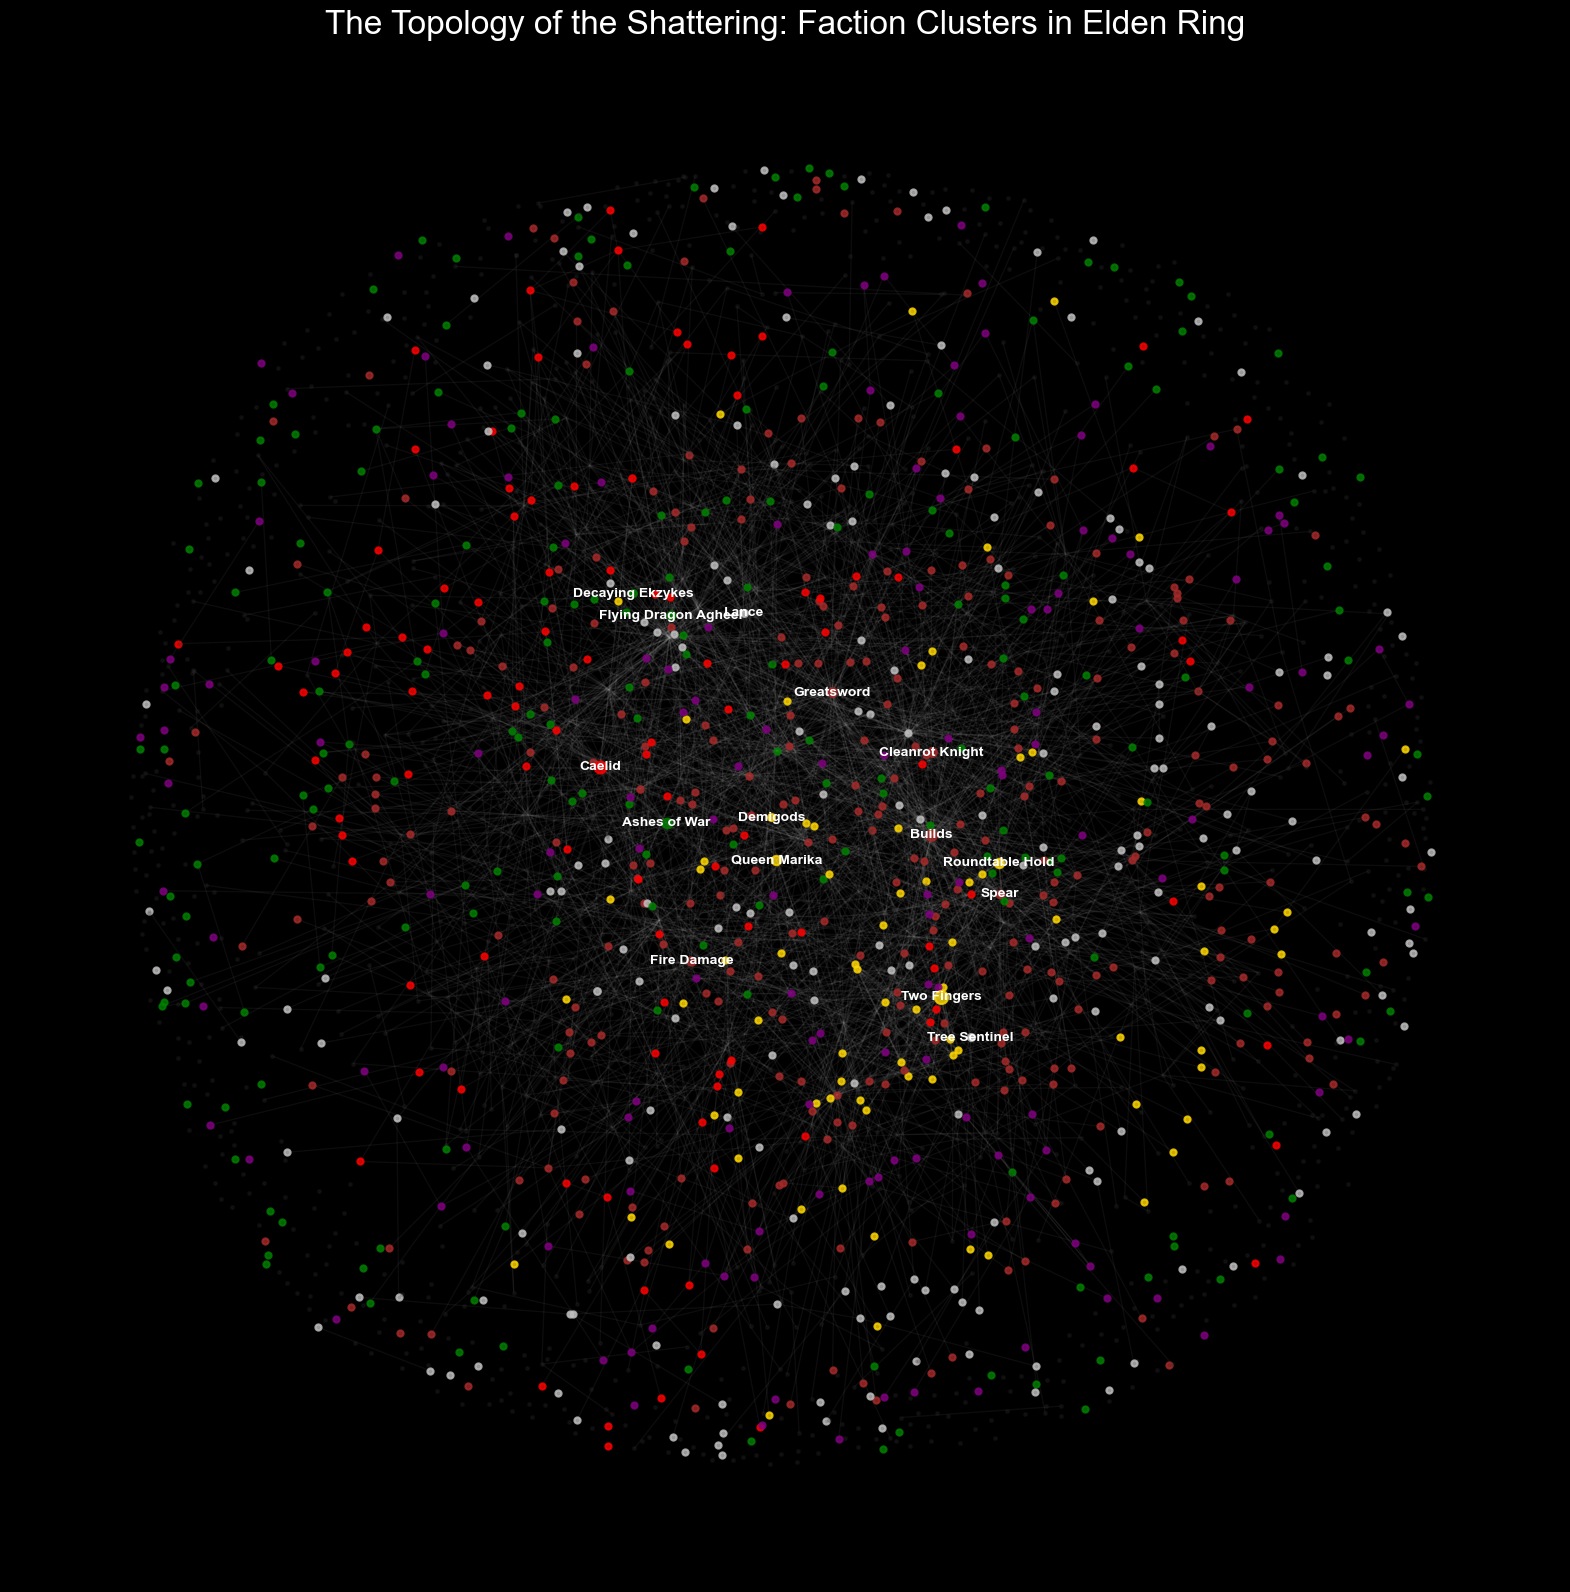

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Load Data
nodes = pd.read_csv("C:/Users/biagu/Documents/GitHub/social_graphs_project/data/processed/nodes_analyzed.csv")
edges = pd.read_csv("C:/Users/biagu/Documents/GitHub/social_graphs_project/data/processed/edges_enriched.csv")

# 2. FILTER NOISE (CRITICAL STEP)
# We remove the Wiki Headers that are clogging your centrality list
noise_list = [
    "Strength", "Dexterity", "Intelligence", "Faith", "Arcane", 
    "Armor", "Weapons", "Bosses", "Items", "Ash of War",
    "Shadow of the Erdtree", "The Lands Between", "Status Effects",
    "Stats", "Runes", "Poison", "Scarlet Rot"
]
nodes_clean = nodes[~nodes['name'].isin(noise_list)]
valid_ids = set(nodes_clean['node_id'])

# Rebuild Graph with only clean nodes
G_vis = nx.Graph()
for _, row in nodes_clean.iterrows():
    G_vis.add_node(row['node_id'], community=row['community'], size=row['centrality'])

for _, row in edges.iterrows():
    if row['source'] in valid_ids and row['target'] in valid_ids:
        G_vis.add_edge(row['source'], row['target'])

# 3. Focus on the "Big 6" Factions (from your logs)
# Communities: 9 (Combat), 6 (Crafting), 41 (Knights), 100 (DLC), 126 (Rot), 81 (Roundtable)
top_comms = [9, 6, 41, 100, 126, 81]
node_colors = []
node_sizes = []
labels = {}

# Map ID to Name for labeling
id_to_name = dict(zip(nodes_clean['node_id'], nodes_clean['name']))

print("Drawing the Map of the Shattering...")
plt.figure(figsize=(20, 20), facecolor='black')

# Position nodes (Force Atlas equivalent)
pos = nx.spring_layout(G_vis, k=0.15, iterations=50, seed=42)

for node in G_vis.nodes():
    comm = G_vis.nodes[node]['community']
    
    # Color logic
    if comm == 126: color = 'red'       # Rot
    elif comm == 81: color = 'gold'     # Roundtable/Order
    elif comm == 100: color = 'purple'  # Shadow/DLC
    elif comm == 41: color = 'silver'   # Knights/Armor
    elif comm == 9: color = 'brown'     # Strength/Raw
    elif comm == 6: color = 'green'     # Crafting/Nature
    else: color = 'grey'                # Others
    
    # Size logic (boost hubs)
    cent = G_vis.nodes[node]['size']
    size = max(20, cent * 5000) 
    
    # Label logic (Only label significant nodes)
    if cent > 0.005 and comm in top_comms:
        labels[node] = id_to_name.get(node, "")
        
    # Draw logic
    if comm in top_comms:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[node], node_color=color, node_size=size, alpha=0.8)
    else:
        # Draw background nodes smaller and fainter
        nx.draw_networkx_nodes(G_vis, pos, nodelist=[node], node_color='#333333', node_size=5, alpha=0.2)

# Draw Faint Edges
nx.draw_networkx_edges(G_vis, pos, alpha=0.05, edge_color='white')

# Draw Labels
nx.draw_networkx_labels(G_vis, pos, labels, font_color='white', font_size=10, font_weight='bold')

plt.title("The Topology of the Shattering: Faction Clusters in Elden Ring", color='white', fontsize=24)
plt.axis('off')
plt.show()

### Golden order propaganda 3.2

Calculating sentiment for visualization...


C:\Users\biagu\AppData\Local\Temp\ipykernel_28600\2794089970.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Category', y='sentiment', data=plot_df,


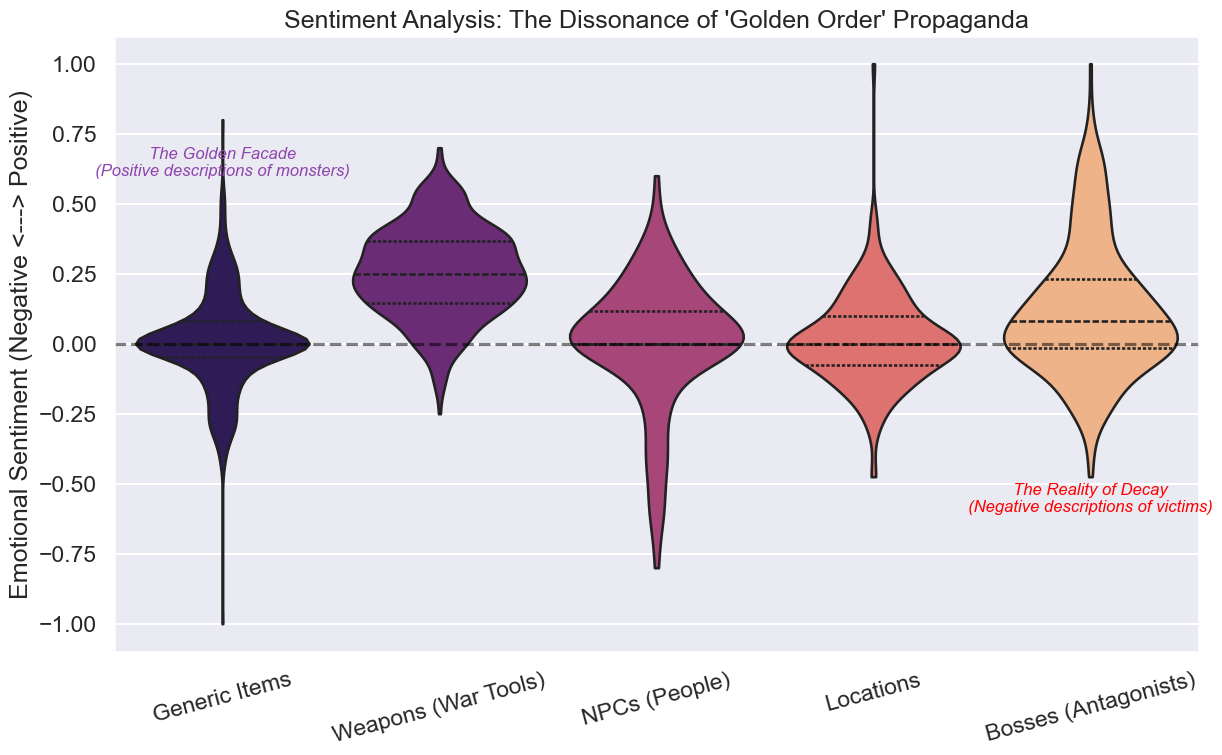

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob

# 1. Load Data
# (We use the file you already have, which contains Community and Centrality)
pd.read_csv("C:/Users/biagu/Documents/GitHub/social_graphs_project/data/processed/nodes_analyzed.csv")

# 2. CRITICAL STEP: Calculate Sentiment
# The file from Notebook 03 doesn't have this column, so we must generate it here.
print("Calculating sentiment for visualization...")
def get_sentiment(text):
    # Handle missing or non-string values safely
    if pd.isna(text): return 0
    text_str = str(text)
    if len(text_str) < 5: return 0
    return TextBlob(text_str).sentiment.polarity

df['sentiment'] = df['description'].apply(get_sentiment)

# 3. Filter for the relevant narrative categories
target_types = ['boss', 'weapon', 'npc', 'location', 'item']
plot_df = df[df['node_type'].isin(target_types)].copy()

# Rename for cleaner plot labels
type_map = {
    'boss': 'Bosses (Antagonists)',
    'weapon': 'Weapons (War Tools)',
    'npc': 'NPCs (People)',
    'location': 'Locations',
    'item': 'Generic Items'
}
plot_df['Category'] = plot_df['node_type'].map(type_map)

# 4. PLOT
plt.figure(figsize=(14, 8))
sns.set_style("darkgrid")
sns.set_context("talk")

# Violin Plot showing density of sentiment
ax = sns.violinplot(x='Category', y='sentiment', data=plot_df, 
                    palette="magma", inner="quartile", cut=0)

# Add Reference Line (Neutral)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

# Annotate the "Propaganda"
plt.text(0, 0.6, "The Golden Facade\n(Positive descriptions of monsters)", 
         color='#8e44ad', ha='center', fontsize=12, style='italic')

plt.text(4, -0.6, "The Reality of Decay\n(Negative descriptions of victims)", 
         color='red', ha='center', fontsize=12, style='italic')

plt.title("Sentiment Analysis: The Dissonance of 'Golden Order' Propaganda", fontsize=18)
plt.ylabel("Emotional Sentiment (Negative <---> Positive)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.show()

## The Tragedy of Commerce (Sociological Findings)

C:\Users\biagu\AppData\Local\Temp\ipykernel_28600\3008051826.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='death_ref_count', y='name', data=top_tragic, palette="Reds_r")


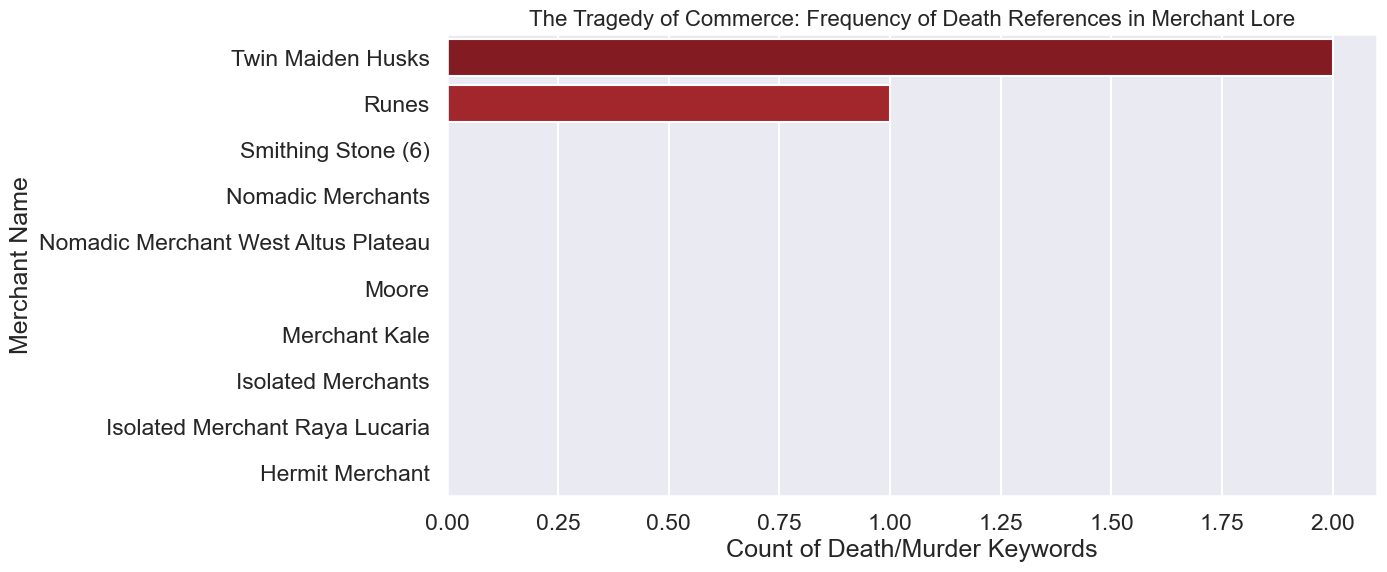

In [22]:
# Create a specific dataframe for Merchants
merchants = df[df['name'].str.contains("Merchant") | df['description'].str.contains("Merchant")].copy()

# Define Tragic Keywords
death_words = ['bell bearing', 'dead', 'corpse', 'killed', 'die', 'murder', 'hunter']
merchants['death_ref_count'] = merchants['description'].apply(lambda x: sum(1 for w in death_words if w in str(x).lower()))

# Sort by Tragedy
top_tragic = merchants.sort_values('death_ref_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='death_ref_count', y='name', data=top_tragic, palette="Reds_r")
plt.title("The Tragedy of Commerce: Frequency of Death References in Merchant Lore", fontsize=16)
plt.xlabel("Count of Death/Murder Keywords")
plt.ylabel("Merchant Name")
plt.show()